In [1]:
from glob import glob

import cv2
import matplotlib.pyplot as plt
import numpy as np

In [4]:
data_path = '/Users/calvinku/Projects/ZiTransfer/fonts/Osaka/320/'

filename_list = glob(data_path + '*.png')

In [15]:
img = cv2.imread(filename_list[0], cv2.IMREAD_GRAYSCALE)

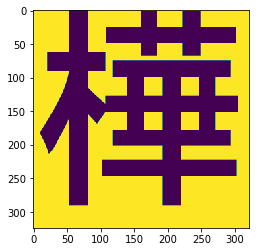

In [16]:
plt.imshow(img)

In [136]:
from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import gaussian_filter

def invert_image(img):
    """
    Invert image.
    """
    return 255 - img

def adjust_margin(img_inv):
    """
    Adjust margin of the image so that the whitespaces at all sides are similar.
    """
    num_rows, num_cols = img_inv.shape
    
    row_ind_list, col_ind_list = np.nonzero(img_inv)
    
    row_min, row_max = row_ind_list.min(), row_ind_list.max()
    col_min, col_max = col_ind_list.min(), col_ind_list.max()
    
    margins = (row_min, (num_rows - row_max), col_min, (num_cols - col_max))
    top_margin, bottom_margin, left_margin, right_margin = margins
    margin_mean = np.mean(margins)
    
    margin_cut_list = [int(margin - margin_mean) if margin - margin_mean > 0 else 0 for margin in margins]
    margin_pad_list = [int(margin_mean - margin) if margin - margin_mean < 0 else 0 for margin in margins]
    
    img_cut = img_inv[margin_cut_list[0]:num_rows - margin_cut_list[1], margin_cut_list[2]:num_cols - margin_cut_list[3]]
    img_pad = cv2.copyMakeBorder(img_cut, margin_pad_list[0], margin_pad_list[1], margin_pad_list[2], margin_pad_list[3], cv2.BORDER_CONSTANT)

    return img_pad

def resize(img, size=320):
    """
    """
    num_rows, num_cols = img_inv.shape
    
    if num_rows == num_cols:
        img_resized = cv2.resize(img,(int(size),int(size)))
        
    elif num_rows > num_cols:
        diff = num_rows - num_cols
        
        if diff % 2:
            img_pad = cv2.copyMakeBorder(img, 0, 0, int(diff // 2), int(diff // 2), cv2.BORDER_CONSTANT)
        else:
            img_pad = cv2.copyMakeBorder(img, 0, 0, int(diff // 2) + 1, int(diff // 2), cv2.BORDER_CONSTANT)
            
        img_resized = cv2.resize(img_pad,(int(size),int(size)))
        
    else:
        diff = num_cols - num_rows
        
        if diff % 2:
            img_pad = cv2.copyMakeBorder(img, int(diff // 2), int(diff // 2), 0, 0, cv2.BORDER_CONSTANT)
        else:
            img_pad = cv2.copyMakeBorder(img, int(diff // 2) + 1, int(diff // 2), 0, 0, cv2.BORDER_CONSTANT)
            
        img_resized = cv2.resize(img_pad,(int(size),int(size)))
    
    print(img_resized.shape)
    
    return img_resized

def scale(img, ratio=0.5):
    num_rows, num_cols = img_inv.shape
    new_rows = int(num_rows * ratio) 
    new_cols = int(num_cols * ratio)
    
    if not new_rows % 2:
        new_rows += 1
    if not new_cols % 2:
        new_cols += 1
    
    row_diff = num_rows - new_rows
    col_diff = num_cols - new_cols
    
    img_scaled = cv2.resize(img, (int(new_rows), int(new_cols)))
    img_scaled = cv2.copyMakeBorder(img_scaled, int(row_diff // 2) + 1, int(row_diff // 2), int(col_diff // 2), int(col_diff // 2), cv2.BORDER_CONSTANT)
    
    return img_scaled

def add_salt_and_pepper(img, prob=0.1):
    '''Adds "Salt & Pepper" noise to an image.
    gb: should be one-channel image with pixels in [0, 1] range
    prob: probability (threshold) that controls level of noise'''

    rnd = np.random.rand(img.shape[0], img.shape[1])
    noisy = img.copy()
    noisy[rnd < prob] = 0
    noisy[rnd > 1 - prob] = 255
    
    return noisy

def add_gaussian(img, mean=0, std=50):
    '''Adds "Salt & Pepper" noise to an image.
    gb: should be one-channel image with pixels in [0, 1] range
    prob: probability (threshold) that controls level of noise'''

    noise = img.copy()
    print(cv2.randn(noise, mean, std).min(), cv2.randn(noise, mean, std).max())
    return img + cv2.randn(noise, mean, std)

def elastic_transform(image, alpha=50, sigma=10, alpha_affine=15, random_state=None): 
    """Elastic deformation of images as described in [Simard2003]_ (with modifications).
    .. [Simard2003] Simard, Steinkraus and Platt, "Best Practices for
         Convolutional Neural Networks applied to Visual Document Analysis", in
         Proc. of the International Conference on Document Analysis and
         Recognition, 2003.
     Based on https://gist.github.com/erniejunior/601cdf56d2b424757de5
    """ 
    if random_state is None: 
        random_state = np.random.RandomState(None) 
    shape = image.shape 
    shape_size = shape[:2] 
    
    # Random affine 
    center_square = np.float32(shape_size) // 2 
    square_size = min(shape_size) // 3
    
    pts1 = np.float32([center_square + square_size, [center_square[0]+square_size, center_square[1]-square_size], center_square - square_size]) 
    pts2 = pts1 + random_state.uniform(-alpha_affine, alpha_affine, size=pts1.shape).astype(np.float32) 
    M = cv2.getAffineTransform(pts1, pts2) 
    image = cv2.warpAffine(image, M, shape_size[::-1], borderMode=cv2.BORDER_REFLECT_101) 
    dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma) * alpha 
    dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma) * alpha 
#     dz = np.zeros_like(dx) 
    
    x, y= np.meshgrid(np.arange(shape[1]), np.arange(shape[0])) 
#     x, y, z = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]), np.arange(shape[2])) 
    indices = np.reshape(y+dy, (-1, 1)), np.reshape(x+dx, (-1, 1))
    
    return map_coordinates(image, indices, order=1, mode='reflect').reshape(shape)

(320, 320)


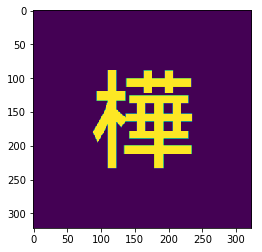

In [115]:
img_inv = invert_image(img)

plt.imshow(scale(resize(adjust_margin(img_inv))))

0 221
0


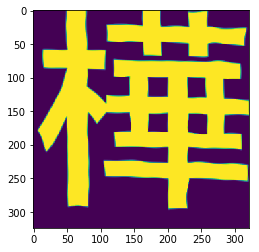

In [226]:
print(add_gaussian(img_inv, mean=0).min())

plt.imshow(elastic_transform(img_inv, 50, 10, 15))
